## New Dark Matter (DM) Simulation 
Using model from ... 

In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import nbformat
import plotly.graph_objects as go
import plotly.express as px
from scipy.integrate import nquad, dblquad
import plotly.io as pio
from tqdm import tqdm
pio.renderers.default = "notebook"

np.set_printoptions(threshold=10)

In [3]:
class DMModel():
    def __init__(self, g=6.67e-11, dmMass=10000, galaxyRadius=5.2e19, meanDensity=2.0e-24):
        self.g = g
        self.dmMass = dmMass
        self.galaxyRadius = galaxyRadius
        self.meanDensity = meanDensity
        

    def RunSimulation(self, numRegions=100, integralSampleNum=500, meanDensity=2.0e-24):
        print("Sectioning galaxy into", (numRegions - 1)**3, "regions.")
        self.SectionGalaxy(numRegions=numRegions)

        print("Integrating sections.")
        self.FindDMCounts(integralSampleNum=integralSampleNum)

        print("Populating galaxy with DM bodies.")
        self.PopulateDMGalaxy()



    def DensityFunction(self, r, theta):
        # Function for radius, dependent on radius from galactic center and angle to the vertical axis.
        # Original function is in 2D

        # Needs better mean density value, this is the DM density at the Sun's position taken from Wikipedia
        # meanDensity = 5.955e-22#(1/3) * 3e-28
        n = 1

        v0 = np.sqrt(4 * np.pi * self.g * self.meanDensity * self.galaxyRadius**2)
        pTheta = (1 + np.cos(theta))**(n + 1) + (1 - np.cos(theta))**(n + 1)
        sTheta = (4 * (n + 1) * np.sin(theta)**(2 * n))/(pTheta)**2
        rDensity = v0**2 / (4 * np.pi * self.g * r**2)
        density = rDensity * sTheta
        return density
    
    
    def SectionGalaxy(self, numRegions=100):
        # Section galaxy into regions, numRegions^3 for each direction.
        # Store rMin, rMax, thetaMin, thetaMax, phiMin, phiMax for each region.
        rArray = np.linspace(0, self.galaxyRadius, numRegions)
        thetaArray = np.linspace(0, np.pi, numRegions)
        phiArray = np.linspace(0, 2*np.pi, numRegions)

        self.regions = []
        for i in range(numRegions - 1):
            for j in range(numRegions - 1):
                for k in range(numRegions - 1):
                    rMin, rMax = rArray[i], rArray[i + 1]
                    thetaMin, thetaMax = thetaArray[j], thetaArray[j + 1]
                    phiMin, phiMax = phiArray[k], phiArray[k + 1]

                    self.regions.append((rMin, rMax, thetaMin, thetaMax, phiMin, phiMax))


    def MonteCarloIntegral(self, N, region):
        # Random array of points within space for r, theta and phi.
        r, theta, phi = self.SampleRegion(region, N)

        regionVolume = (
            (region[1]**3 - region[0]**3)/3 *
            (np.cos(region[2]) - np.cos(region[3])) *
            (region[5] - region[4])
        )
        values = self.DensityFunction(r, theta)
        
        return regionVolume * np.mean(values)


    def FindDMCounts(self, integralSampleNum=500):
        # Integrate over each region of the galaxy to get total mass.
        #
        # Then divide total mass by DM Mass to get N for number of particles.
        self.regionMasses = np.array([
            self.MonteCarloIntegral(integralSampleNum, region)
            for region in tqdm(self.regions, desc="Integrating")
        ])

        # Until I find a way to deal with trillions of particles, 
        # I make the DM Mass larger by a factor of however many digits long the avg number of 
        # DM counts there are in each region.
        # This adjusts the DM Mass enough so that the average number of DM per region is < 10.
        #
        # For a million+ regions that will have to do for now
        dmCounts = self.regionMasses / self.dmMass
        if np.mean(dmCounts) > 10:
            avgDMCount = int(np.mean(dmCounts))
            numDigits = len(list(str(avgDMCount)))  # Find how many digits
            self.dmMass *= 10**(numDigits - 1)

            
            print("Multiplied DM Mass by 10^" + str(numDigits) + " to improve performance.")
            print("DM Mass is now", self.dmMass, "kg")

        self.numDM = self.regionMasses / self.dmMass
        # print(self.numDM)
    
    def GetDMCounts(self):
        return self.numDM
    
    def SphericalToCartesian(self, r, theta, phi):
        x = r * np.sin(theta) * np.cos(phi)
        y = r * np.sin(theta) * np.sin(phi)
        z = r * np.cos(theta)
        return np.column_stack((x, y, z))
    
    def SampleRegion(self, region, N):
        rMin, rMax, thetaMin, thetaMax, phiMin, phiMax = region

        u1 = np.random.rand(N)
        u2 = np.random.rand(N)

        r = (u1 * (rMax**3 - rMin**3) + rMin**3)**(1/3)
        theta = np.arccos(
                np.cos(thetaMin) - u2 * (np.cos(thetaMin) - np.cos(thetaMax))
            )
        phi = np.random.uniform(phiMin, phiMax, N)

        return r, theta, phi
    
    
    def PopulateDMGalaxy(self):
        # With number of particles per region, now it's time to create a matrix with all DM particles.
        #
        # For decimals, summon as many as the last whole integer and subtract that from the total number of particles.
        # With the remaining decimal (<1), invert the number (1/decimal) and pick a random number between 1 and the nearest integer.
        # If the random number is 1 then an additional particle is summoned, otherwise it is not.

        allPositions = []
        for i in range(len(self.regions)):

            N = int(self.numDM[i])
            frac = self.numDM[i] - N
            if np.random.rand() < frac:
                N += 1

            r, theta, phi = self.SampleRegion(self.regions[i], N)
            positions = self.SphericalToCartesian(r, theta, phi)

            allPositions.append(positions)
        
        self.dmCartesianCoordinates = np.vstack(allPositions)
        return self.dmCartesianCoordinates

    def FindOrbitalVelocity(self, M, r):
        return np.sqrt(self.g * M / r)


    def GetRotationCurve(self, N = 10, maxRadiusKPc=12):
        # Summons N randomly placed test particles in the galaxy of DM.
        # Find the total mass of DM particles inside the radius of the test particles, 
        # then use that to find the orbital velocity required to have a stable circular orbit at that radius.
        kPcToM = 3.086e+19
        fullRegion = (0, maxRadiusKPc * kPcToM, 0, np.pi, 0, 2*np.pi)
        r, theta, phi = self.SampleRegion(fullRegion, N)

        self.testParticlesCartesianCoordinates = self.SphericalToCartesian(r, theta, phi)

        dmRadii = np.linalg.norm(self.dmCartesianCoordinates, axis=1)
        testRadii = np.linalg.norm(self.testParticlesCartesianCoordinates, axis=1)

        interiorCounts = np.array([np.sum(dmRadii < R) for R in testRadii])
        print(interiorCounts)
        interiorMasses = interiorCounts * self.dmMass
        orbitalVelocities = self.FindOrbitalVelocity(interiorMasses, testRadii)

        self.PlotRotationCurve2D(testRadii, orbitalVelocities)


    def TestMonteCarloAccuracy(self, numTestRegions = 10):
        testRegions = np.random.randint(0, len(self.regions), numTestRegions)

        monteMasses = [self.regionMasses[i] for i in testRegions]
        quadMasses = []
        for i in testRegions:
            # i is the index for the region in either self.regions and self.regionMasses
            rMin, rMax, thetaMin, thetaMax, phiMin, phiMax = self.regions[i]

            # Density is independent of phi
            phiWidth = phiMax - phiMin

            # Integrand for dblquad
            def integrand(r, theta):
                return self.DensityFunction(r, theta) * r**2 * np.sin(theta)

            # Fixed r bounds
            rLower = lambda theta: rMin
            rUpper = lambda theta: rMax

            # Integrate
            innerIntegral, error = dblquad(
                integrand,
                thetaMin, thetaMax,
                rLower, rUpper 
            )

            quadMass = innerIntegral * phiWidth
            quadMasses.append(quadMass)

            print("For region", i, "quad integral got", quadMass, "and Monte got", self.regionMasses[i])

        integrationError = [abs(quadMasses[i] - monteMasses[i]) / quadMasses[i] for i in range(numTestRegions)]
        return integrationError
    

    def PlotDMPositions3D(self, alpha = 0.1, lineWidth = 0.001, N=100000):
        mTokPc = 3.24078e-20
        plotDimensions = self.galaxyRadius * mTokPc
        
        randomSample = np.random.randint(0, len(self.dmCartesianCoordinates), N)
        X = [self.dmCartesianCoordinates[i][0] * mTokPc for i in randomSample]
        Y = [self.dmCartesianCoordinates[i][1] * mTokPc for i in randomSample]
        Z = [self.dmCartesianCoordinates[i][2] * mTokPc for i in randomSample]

        df = pd.DataFrame({
                "X": X,
                "Y": Y,
                "Z": Z
            })

        fig = px.scatter_3d(
            data_frame=df,
            x="X",
            y="Y",
            z="Z",
            opacity=alpha,
            # size=lineWidth
        )
        fig.update_layout(
            scene=dict(
                xaxis=dict(range=[-plotDimensions, plotDimensions], title="X (kPc)"),
                yaxis=dict(range=[-plotDimensions, plotDimensions], title="Y (kPc)"),
                zaxis=dict(range=[-plotDimensions, plotDimensions], title="Z (kPc)")
            )
        )

        fig.show()
    
    def PlotRotationCurve2D(self, x, y):
        mTokPc = 3.24078e-20
        mpsTokps = 10**-3
        x *= mTokPc
        y *= mpsTokps
        
        fig = plt.figure(figsize=(16,12))
        ax = fig.add_subplot(111)

        ax.scatter(x, y)
        ax.set_xlabel("Radius from GC (kPc)")
        ax.set_ylabel("Orbital Velocity (km/s)")
        plt.show()

    

In [4]:
model = DMModel(dmMass=1e22, galaxyRadius=6e21, meanDensity=2e-24)
model.RunSimulation(numRegions=100)

Sectioning galaxy into 970299 regions.
Integrating sections.


Integrating: 100%|██████████| 970299/970299 [00:36<00:00, 26635.86it/s]


Multiplied DM Mass by 10^15 to improve performance.
DM Mass is now 1e+36 kg
Populating galaxy with DM bodies.


In [5]:
model.PlotDMPositions3D(alpha = 0.005, lineWidth=0.01, N = 100000)

[814532 816542 392071 ... 824514 794898 459026]


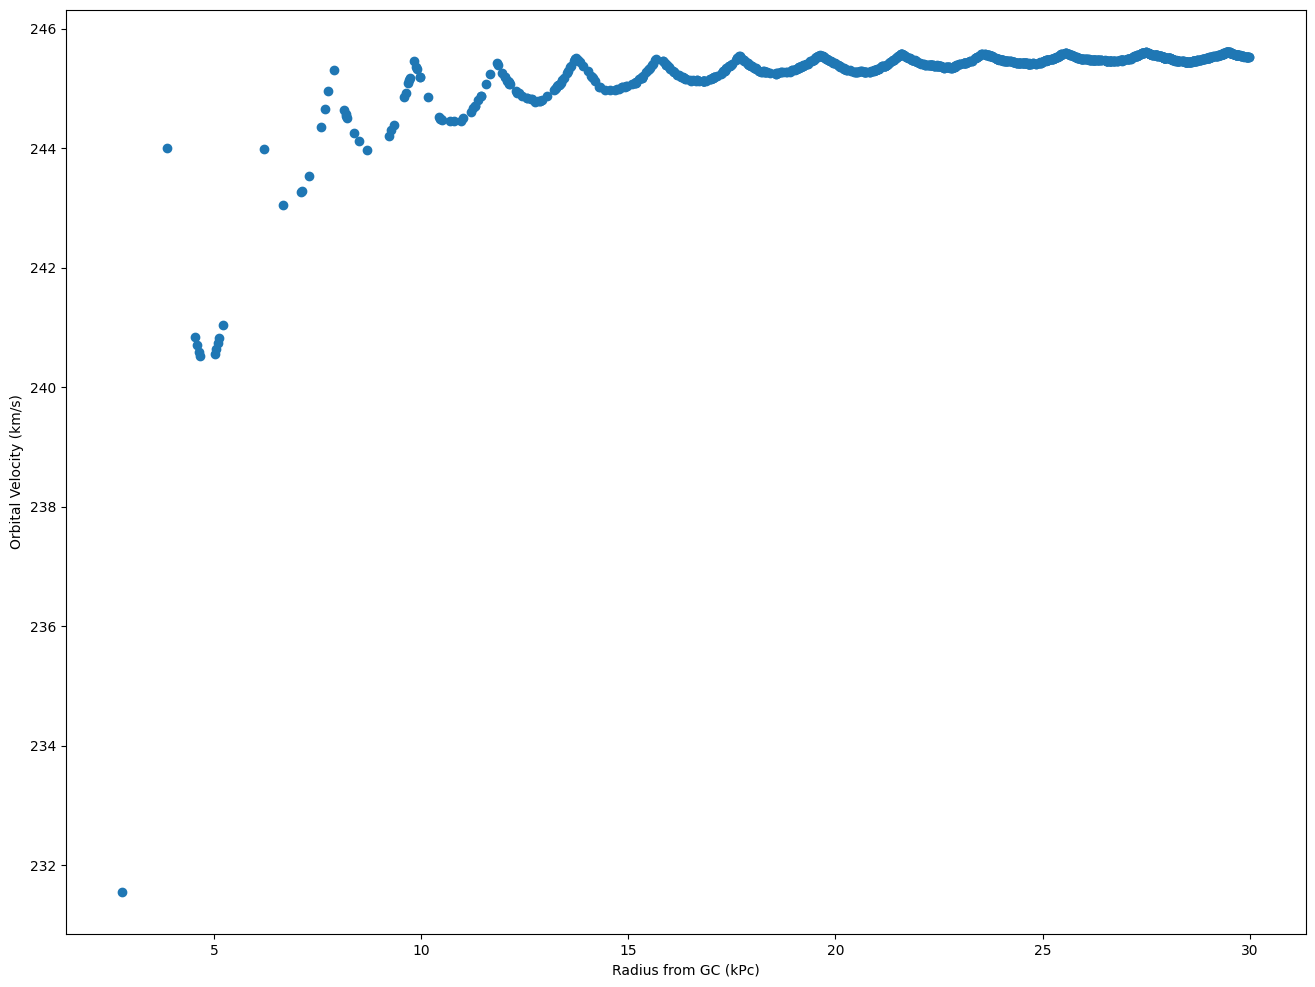

In [6]:
model.GetRotationCurve(N=1000, maxRadiusKPc=30)

In [7]:
model.dmCartesianCoordinates

array([[-6.55641635e+18, -3.51471450e+18,  5.75621838e+19],
       [ 6.50618960e+18, -3.48415485e+18,  5.73445936e+19],
       [ 7.52243829e+18,  2.01420943e+18,  3.91951500e+19],
       ...,
       [-7.89088614e+20, -6.24576817e+19, -5.93263081e+21],
       [-3.13330521e+20, -2.69181912e+20, -5.92699193e+21],
       [ 2.93181519e+20, -3.57234349e+20, -5.92692089e+21]],
      shape=(5428229, 3))

In [8]:
dmCounts = model.GetDMCounts()
print("The region with the fewest DM Bodies has", np.min(dmCounts))
print("The region with the Most DM Bodies has", np.max(dmCounts))
print("The average DM Bodies per region is", np.mean(dmCounts))
#print(np.sum(dmCounts))
print("Total mass of Dark Matter in galaxy (kg) =", np.sum(dmCounts) * model.dmMass)
print("Estimated mass of the Milky Way Galaxy =", 1.15e12 * 1.989e30)
print("This models DM mass percentage =", (np.sum(dmCounts) * model.dmMass * 100) / (1.15e12 * 1.989e30), "%")

The region with the fewest DM Bodies has 2.5967993173309037e-05
The region with the Most DM Bodies has 232.07556398405205
The average DM Bodies per region is 5.594533560299567
Total mass of Dark Matter in galaxy (kg) = 5.4283703190251095e+42
Estimated mass of the Milky Way Galaxy = 2.28735e+42
This models DM mass percentage = 237.32136835312085 %


In [9]:
integrationError = model.TestMonteCarloAccuracy()

For region 537064 quad integral got 1.4647768515782542e+36 and Monte got 1.4626525309006637e+36
For region 545155 quad integral got 1.0857304642221351e+37 and Monte got 1.086303945008763e+37
For region 426236 quad integral got 1.7509813789917365e+37 and Monte got 1.7520481588383505e+37
For region 441580 quad integral got 2.392124674528875e+34 and Monte got 2.3913359287715486e+34
For region 393672 quad integral got 7.182570794653615e+35 and Monte got 7.182515894842708e+35
For region 522851 quad integral got 8.431726976750488e+36 and Monte got 8.414761290994432e+36
For region 965997 quad integral got 1.5506927882427018e+37 and Monte got 1.551647458242638e+37
For region 783017 quad integral got 1.7204557914953916e+35 and Monte got 1.724430855764576e+35
For region 805593 quad integral got 1.2407126210891012e+36 and Monte got 1.2451815879169605e+36
For region 404172 quad integral got 2.3176715469832782e+36 and Monte got 2.326324319477325e+36


In [10]:
integrationError

[np.float64(0.0014502691487113728),
 np.float64(0.0005281981168676446),
 np.float64(0.0006092468254735776),
 np.float64(0.00032972602378332787),
 np.float64(7.643476476118156e-06),
 np.float64(0.0020121246575981913),
 np.float64(0.0006156409620103016),
 np.float64(0.002310471613879315),
 np.float64(0.003601935494084392),
 np.float64(0.003733390309472243)]